In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.cluster import KMeans

plt.style.use('ggplot')


def plot_many_barh(data: pd.DataFrame, nrows: int = 4, ncols: int = 3, figsize: tuple = (20, 20)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    columns = data.columns.tolist()
    current_col_to_plot = 0
    for row in range(nrows):
        for col in range(ncols):
            try:
                column_name = columns[current_col_to_plot]
            except IndexError:
                break

            vc = data[column_name].value_counts()
            axes[row, col].bar(vc.index, vc.values, label=column_name)
            axes[row, col].tick_params(axis='x', rotation=20)
            axes[row, col].set_title(column_name)

            current_col_to_plot += 1

    plt.tight_layout()
    plt.show()


def plot_many_hist(data: pd.DataFrame, nrows: int = 4, ncols: int = 3, figsize: tuple = (20, 20)):
    columns = data.columns.tolist()

    if len(columns) > nrows * ncols:
        nrows = len(columns) // ncols + int(len(columns) % ncols != 0)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
    current_col_to_plot = 0
    for row in range(nrows):
        for col in range(ncols):
            try:
                column_name = columns[current_col_to_plot]
            except (IndexError, TypeError):
                break

            axes[row, col].hist(data[column_name], bins=100)
            axes[row, col].tick_params(axis='x', rotation=20)
            axes[row, col].set_title(column_name)

            current_col_to_plot += 1

    plt.tight_layout()
    plt.show()



## Часть 1

### Преобразование данных

In [ ]:
df = pd.read_csv('/Users/ivanzubkov/Desktop/SAS', sep=';', index_col='ID').drop(columns=['ID'])
desc = pd.read_csv(
    '/Users/ivanzubkov/Desktop/SAS/Описание параметров_Description of parameters_sas.csv',
    sep=';',
    encoding='cp1251',
    index_col='Атрибуты',
    usecols=['Атрибуты', 'Описание']
).drop(index=['ID'])

desc['dtype'] = desc.index.map(df.dtypes)
categorical_features = desc.loc[desc['dtype'] == 'object'].index.tolist()
numerical_features = desc.loc[desc['dtype'] != 'object'].index.tolist()
desc.loc[categorical_features]
desc

,Описание,dtype
Атрибуты,,
INCOME_BASE_TYPE,Подтверждение дохода,object
CREDIT_PURPOSE,Цель получения кредита,object
INSURANCE_FLAG,Страхование заемщика при получении кредита,float64
DTI,debt-to-income ratio — отношение долга к доходам,object
SEX,Пол,object
FULL_AGE_CHILD_NUMBER,Кол-во лет ребенку,int64
DEPENDANT_NUMBER,Кол-во иждивенцев,int64
EDUCATION,Образование,object
EMPL_TYPE,Должность,object


В первую очередь необходимо разобраться, почему казалось бы числовые метрики приняли нечисловые типы данных при чтении csv - файла

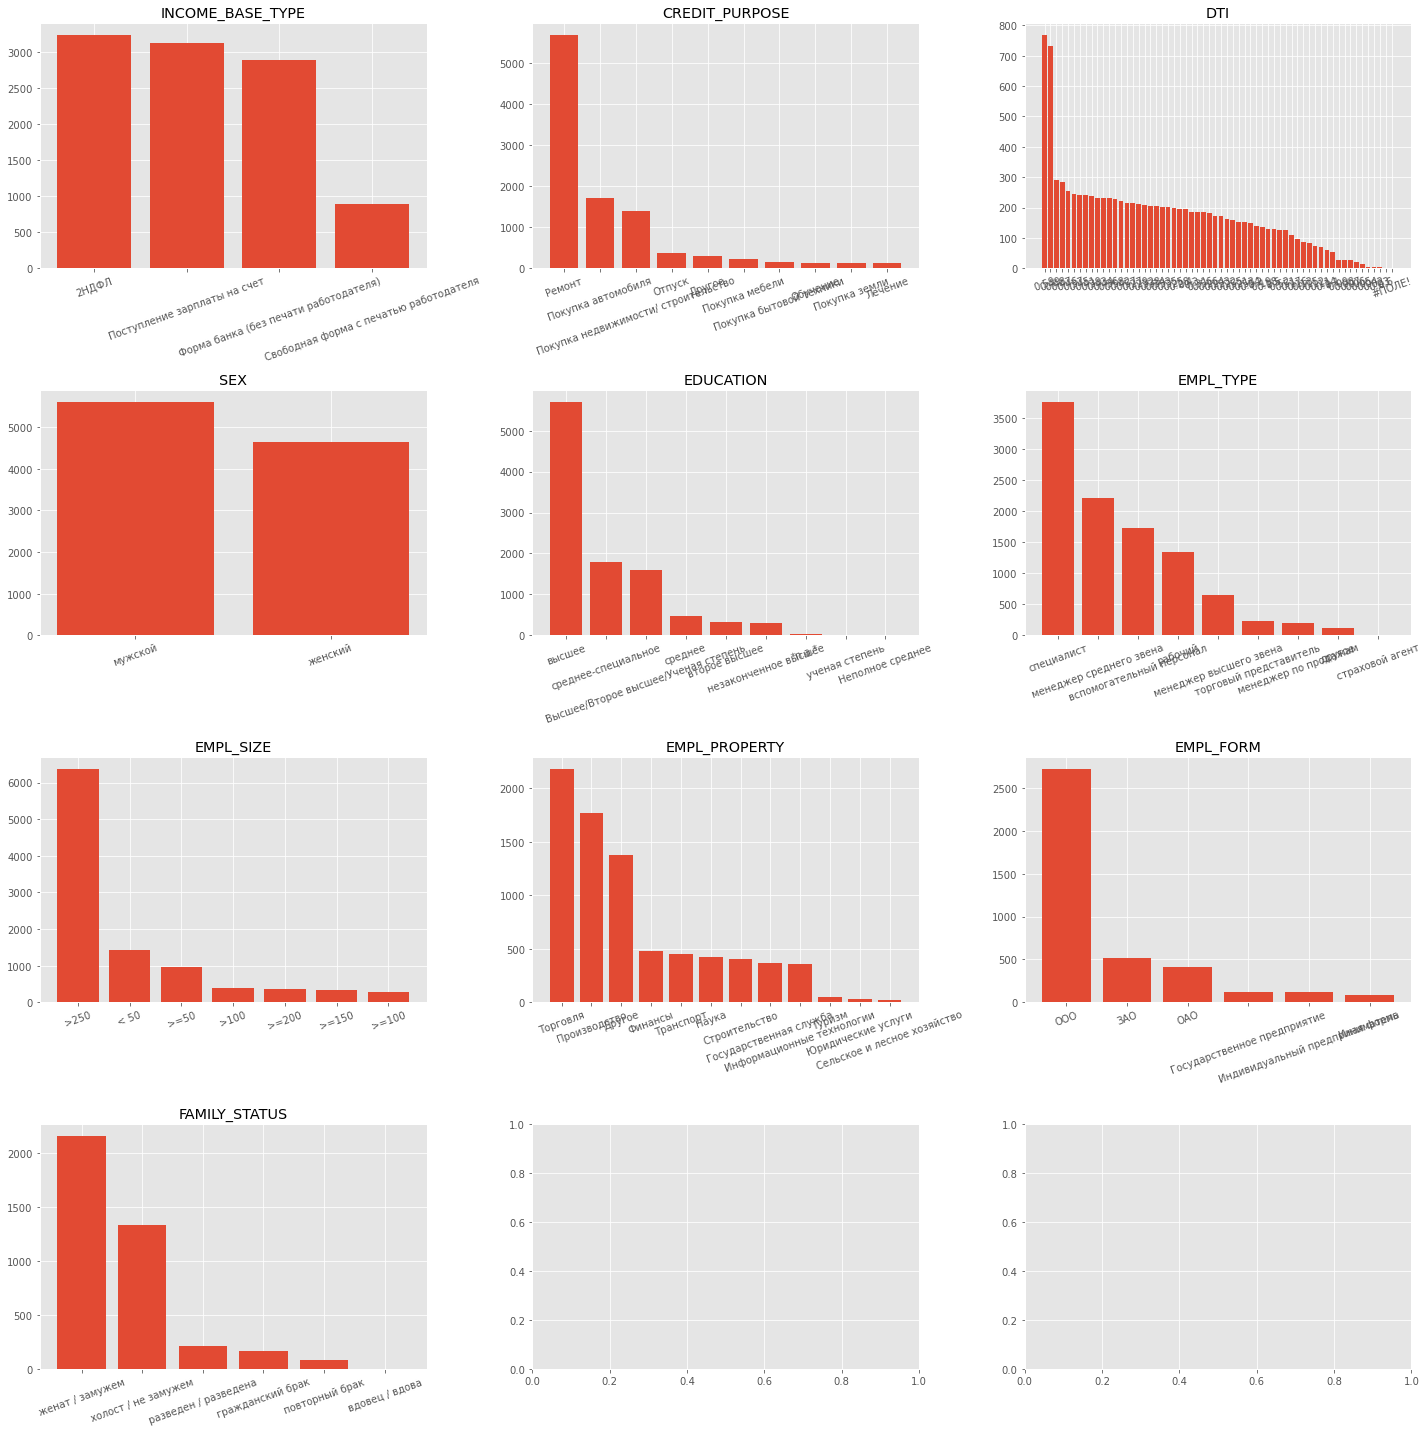

In [ ]:
plot_many_barh(df.loc[:, categorical_features])

#### Категориальные переменные

Говоря о категориальных переменных, следует отметить некоторые закономерности, заметные из их распределений:

1. Большинство запросов на кредит ставят своей целью - проведение ремонта
2. В большинстве своем запросы на кредит поступают от женатых людей
3. Большинство заемщиков с высшим образованием и с зарплатой более 250 тыс.



Заметим, что все признаки, кроме ```DTI``` являются категориальными признаками, ```DTI``` и по смыслу и по распределению похож на числовой признак, который не получилось преобразовать пандасом в виду наличия значений ```#ПОЛЕ!```

Заменим такие значения на ```np.nan``` и преобразуем признак в числовой вид

In [ ]:
# посмотрим на такую строку в таблице
display(df[df['DTI'] == '#ПОЛЕ!'])

df['DTI'] = df['DTI'].replace({'#ПОЛЕ!': np.nan}).astype(float)
display(df[df['DTI'] == '#ПОЛЕ!']) # убедились, что теперь такой строки нет

categorical_features = set(categorical_features)
categorical_features.remove('DTI')
categorical_features = list(categorical_features)

numerical_features.append('DTI')

,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,EMPL_TYPE,EMPL_SIZE,...,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
ID,,,,,,,,,,,,,,,,,,,,,
1028944,Поступление зарплаты на счет,Ремонт,0.0,#ПОЛЕ!,мужской,0,0,среднее-специальное,вспомогательный персонал,>250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,EMPL_TYPE,EMPL_SIZE,...,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
ID,,,,,,,,,,,,,,,,,,,,,


#### Числовые признаки (корреляционная матрица)

Заметно, что в целом признаки нескоррелированы между собой, что делает линейно-регрессионный анализ не совсем уместным.



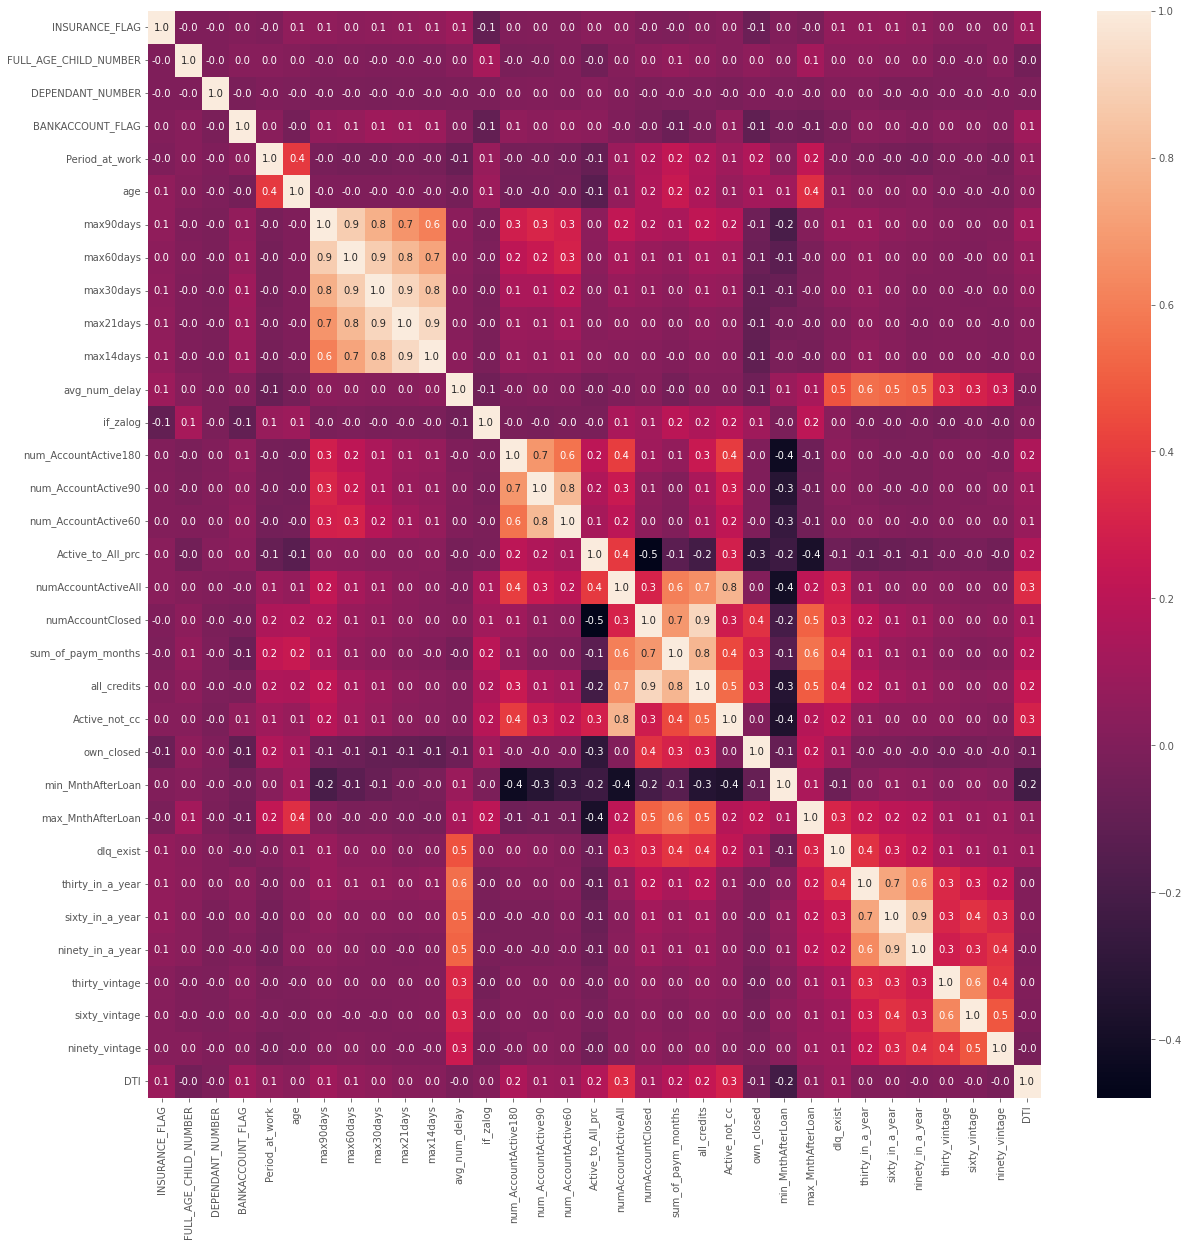

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(df[numerical_features].corr(), annot=True, fmt='.1f')
plt.show()

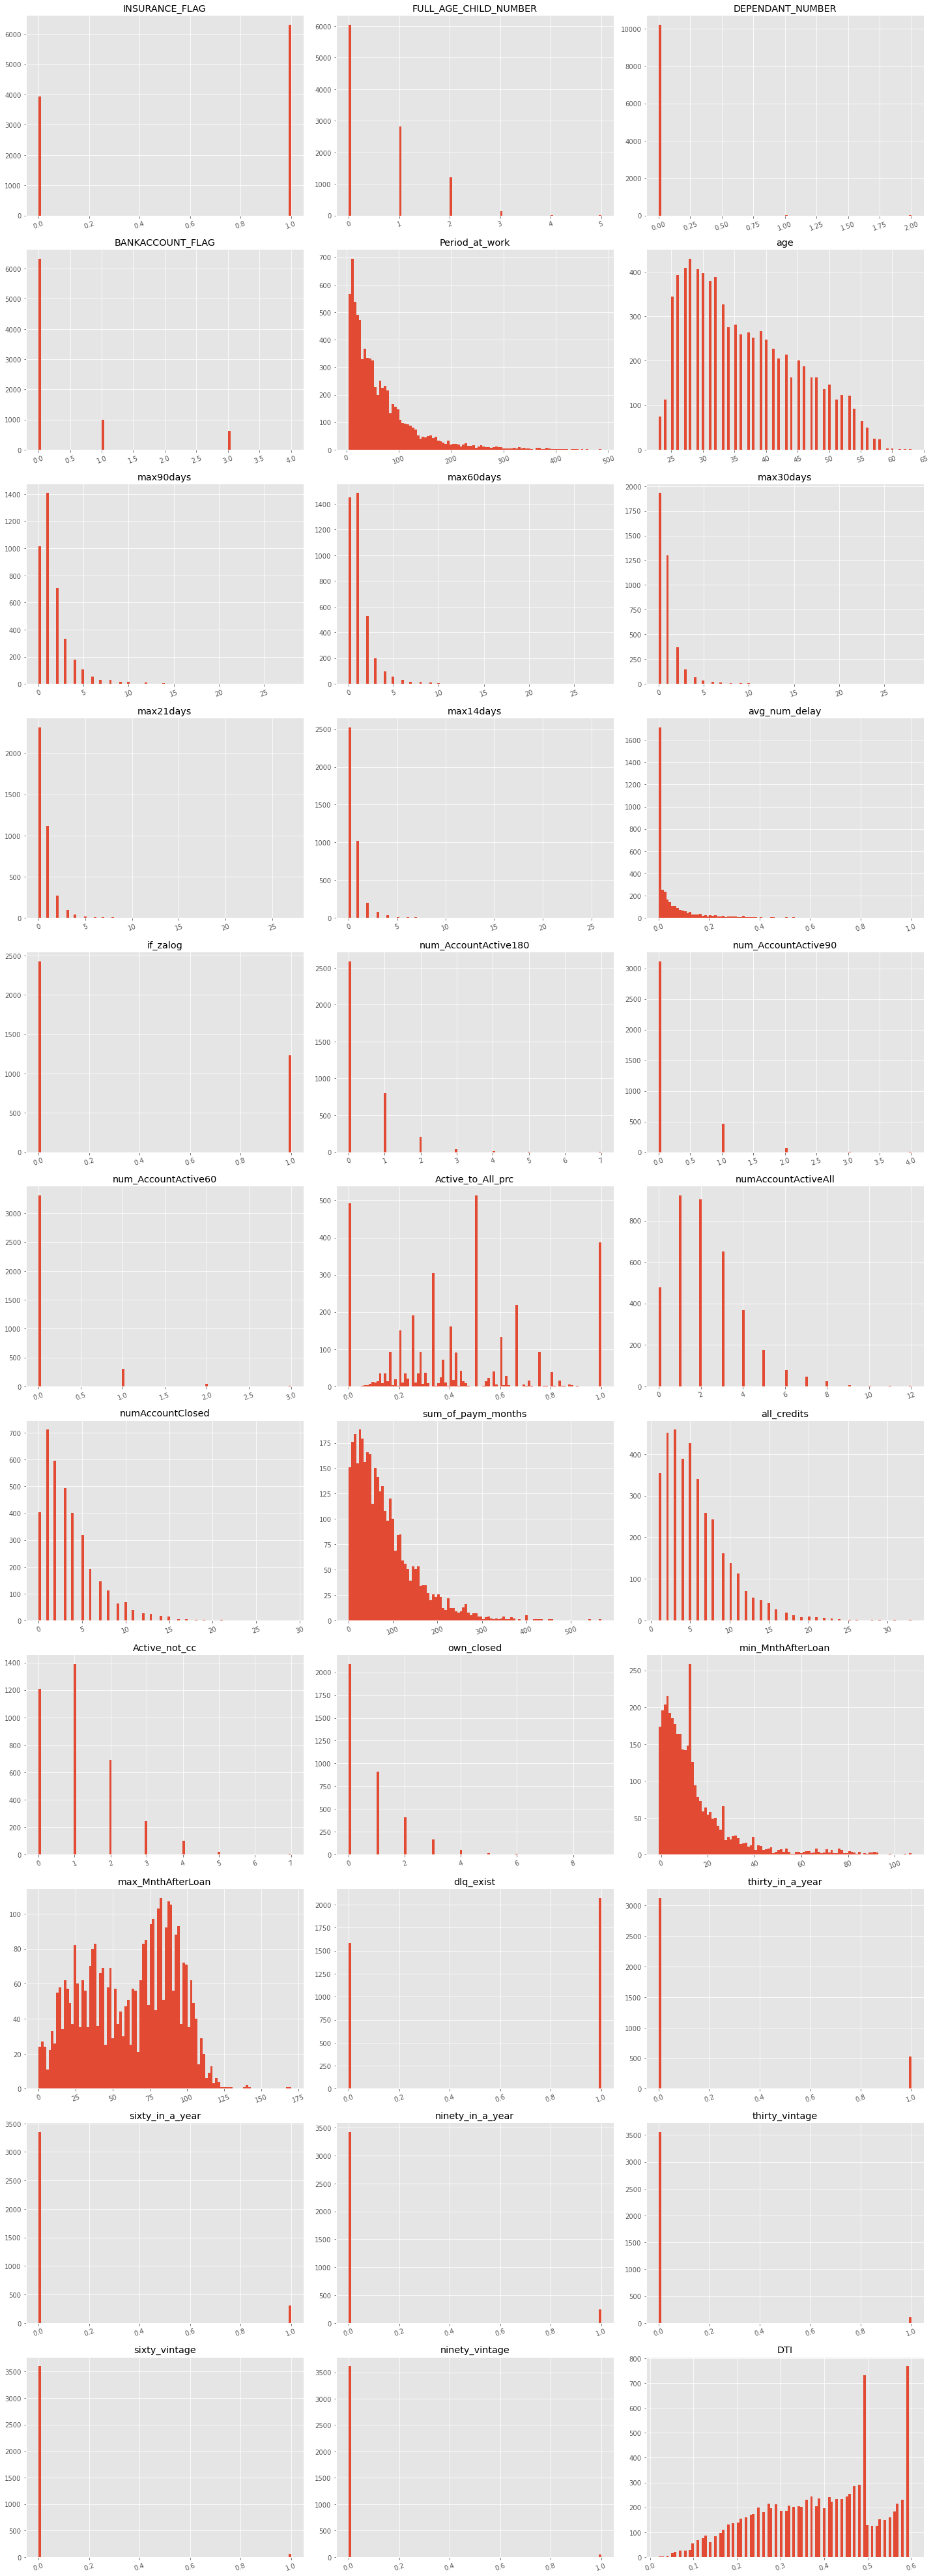

In [ ]:
plot_many_hist(df[numerical_features])

#### Общие характеристики

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
INSURANCE_FLAG,10241.0,0.615272,0.486555,0.00,0.000000,1.000000,1.000000,1.0
DTI,10113.0,0.387109,0.137084,0.02,0.280000,0.400000,0.490000,0.6
FULL_AGE_CHILD_NUMBER,10243.0,0.562238,0.770545,0.00,0.000000,0.000000,1.000000,5.0
DEPENDANT_NUMBER,10243.0,0.004003,0.077070,0.00,0.000000,0.000000,0.000000,2.0
BANKACCOUNT_FLAG,7933.0,0.360267,0.839064,0.00,0.000000,0.000000,0.000000,4.0
Period_at_work,7930.0,65.195965,64.824864,4.00,20.000000,45.000000,86.000000,486.0
age,7933.0,36.286399,8.614798,23.00,29.000000,35.000000,43.000000,63.0
max90days,3908.0,1.644319,1.971619,0.00,0.000000,1.000000,2.000000,28.0
max60days,3908.0,1.170420,1.619603,0.00,0.000000,1.000000,1.000000,28.0
max30days,3908.0,0.874872,1.409483,0.00,0.000000,1.000000,1.000000,28.0


Заметим, что признак ```min_MnthAfterLoan``` имеет минимальное значение равное -1, что выглядит странным

Заменим такие строки на пропущенное значение

In [ ]:
df['min_MnthAfterLoan'] = df['min_MnthAfterLoan'].replace({-1: np.nan})

### Обработка пропущенных значений

In [ ]:
# считаем пропуски, уникальные значения, нулевые значения
column_stats = []
for col in df.columns:
    length = df.shape[0]
    tmp = {
        'name': col,
        'NaNs': df[col].isna().sum(),
        'Nans_perc': df[col].isna().sum() / length,
        'unique': df[col].nunique(),
        'unique_perc': df[col].nunique() / length,
        'zero': df.loc[df[col] == 0].shape[0],
        'zero_perc': df.loc[df[col] == 0].shape[0] / length,
    }
    column_stats.append(tmp)

column_stats = (pd
    .DataFrame(column_stats)
    .set_index('name')
    .join(desc)
    .sort_values(by='Описание', ascending=False)
).loc[:, ['Описание', 'NaNs', 'zero', 'unique', 'Nans_perc', 'zero_perc', 'unique_perc']]

column_stats.style.background_gradient(cmap='Blues')


,Описание,NaNs,zero,unique,Nans_perc,zero_perc,unique_perc
name,,,,,,,
sum_of_paym_months,сумма платежей за последний месяц (тыс.),6585,17,319,0.642878,0.001660,0.031143
ninety_vintage,"просрочка больше 90 дней, когда-либо",6585,3615,2,0.642878,0.352924,0.000195
ninety_in_a_year,просрочка больше 90 дней за последний год,6585,3421,2,0.642878,0.333984,0.000195
sixty_vintage,"просрочка больше 60 дней, когда-либо",6585,3601,2,0.642878,0.351557,0.000195
sixty_in_a_year,просрочка больше 60 дней за последний год,6585,3349,2,0.642878,0.326955,0.000195
thirty_vintage,"просрочка больше 30 дней, когда-либо",6585,3554,2,0.642878,0.346969,0.000195
thirty_in_a_year,просрочка больше 30 дней за последний год,6585,3125,2,0.642878,0.305086,0.000195
Active_to_All_prc,отношение активных счетов ко всем счетам,6585,492,96,0.642878,0.048033,0.009372
dlq_exist,наличие просрочки на данный момент,6585,1585,2,0.642878,0.154740,0.000195


Видно, что в имеющемся наборе данных довольно много пропущенных значений - в ряде столбцов >60%

Удаление пропущенных значений или же заполнение средним/медианой/модой может значительно сократить выборку или исказить ее, поэтому нужно подойти к таким признакам по особенному.

Стратегия заполнения пропущенных значений будет следующей:
- Категориальные переменные:
    * Бинарные переменные - заполняем ```-1```
    * Небинарные переменные с <25% пропусков - заполняем ```модой```
    * Небинарные переменные с >25% пропусков - заполняем ```-100``` - рандомное отрицательное число
- Числовые признаки:
    * Если пропусков меньше 25%, то заполняем ```медианой```
    * Если больше - ```-100```

In [ ]:
binary_features = column_stats[column_stats['unique'] == 2].index.tolist()
for col in binary_features:
    df[col].fillna(-1, inplace=True)


cat_less_25 = column_stats[
    (column_stats['unique'] > 2) &
    (column_stats['unique'] < 15) &
    (column_stats['Nans_perc'] <= 0.25)
].index.tolist()


for col in cat_less_25:
    df[col].fillna(df[col].mode(), inplace=True)
cat_more_25 = column_stats[
    (column_stats['unique'] > 2) &
    (column_stats['unique'] < 15) &
    (column_stats['Nans_perc'] > 0.25)
].index.tolist()


for col in cat_more_25:
    df[col].fillna(-100, inplace=True)

for col in numerical_features:
    if column_stats.loc[col, 'Nans_perc'] < 0.25:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(-100, inplace=True)
df

,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,EMPL_TYPE,EMPL_SIZE,...,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
ID,,,,,,,,,,,,,,,,,,,,,
1000004,Поступление зарплаты на счет,Ремонт,1.0,0.25,женский,0,0,незаконченное высшее,рабочий,>250,...,0.0,3.0,78.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1000024,Поступление зарплаты на счет,Ремонт,0.0,0.37,женский,0,0,высшее,менеджер среднего звена,>=50,...,-100.0,-100.0,-100.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1000044,Поступление зарплаты на счет,Ремонт,0.0,0.47,женский,0,0,высшее,специалист,>250,...,0.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000064,2НДФЛ,Ремонт,0.0,0.40,женский,1,0,высшее,специалист,NaN,...,-100.0,-100.0,-100.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1000084,2НДФЛ,Ремонт,1.0,0.28,мужской,2,0,среднее-специальное,рабочий,>250,...,-100.0,-100.0,-100.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204764,2НДФЛ,Ремонт,1.0,0.39,мужской,0,0,высшее,менеджер среднего звена,>=50,...,-100.0,-100.0,-100.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1204784,Форма банка (без печати работодателя),Ремонт,1.0,0.42,мужской,2,0,Высшее/Второе высшее/Ученая степень,менеджер высшего звена,>250,...,-100.0,-100.0,-100.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1204804,Поступление зарплаты на счет,Ремонт,1.0,0.49,женский,0,0,высшее,менеджер среднего звена,>250,...,1.0,9.0,85.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Перекодирование категориальных признаков

Для кодирования будем использовать способ ```OneHotEncoding```

In [ ]:
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

## Часть 2

### Предобработка данных

Все же для увеличения точности моделей было решено удалить колонки, в которых пропусков было 50+%

In [ ]:
for col in df.columns:

    if col in column_stats.index and column_stats.loc[col, 'Nans_perc'] > 0.5:
        df.drop(columns=[col, ], inplace=True)

df.head()

,INSURANCE_FLAG,DTI,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,BANKACCOUNT_FLAG,Period_at_work,age,SEX_мужской,EMPL_PROPERTY_Другое,EMPL_PROPERTY_Информационные технологии,...,EDUCATION_ученая степень,CREDIT_PURPOSE_Лечение,CREDIT_PURPOSE_Обучение,CREDIT_PURPOSE_Отпуск,CREDIT_PURPOSE_Покупка автомобиля,CREDIT_PURPOSE_Покупка бытовой техники,CREDIT_PURPOSE_Покупка земли,CREDIT_PURPOSE_Покупка мебели,CREDIT_PURPOSE_Покупка недвижимости/ строительство,CREDIT_PURPOSE_Ремонт
ID,,,,,,,,,,,,,,,,,,,,,
1000004,1.0,0.25,0,0,0.0,70.0,50.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1000024,0.0,0.37,0,0,0.0,45.0,35.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1000044,0.0,0.47,0,0,0.0,10.0,25.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1000064,0.0,0.40,1,0,1.0,71.0,31.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1000084,1.0,0.28,2,0,0.0,174.0,50.0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Кластеризация с учителем (Decision Tree Classifier)

Преимущества:

- Легкая интерпретируемость результатов
- Интерпретация не зависит от интерпретирующего человека, границы разделения кластеров четко обозначаются - исключается вероятность ошибки

Недостатки:
- Деревья склонны переобучаться и подстраиваться под выборку -> зависимость от конкретной выборки (необходимость большой и хорошо составленной репрезентативной выборки)
- Интерпретируемость дерева зависит от параметра ```max_depth``` - если поставить глубину дерева слишком большой, то
адекватно объяснить выбор кластеров будет довольно сложно, поэтому необходимо ограничить значения этого параметра сверху (3 или 4, например)

Одним из наиболее равномерно распределенных числовых признаков является возраст, классы по нему будут более сбалансированы.

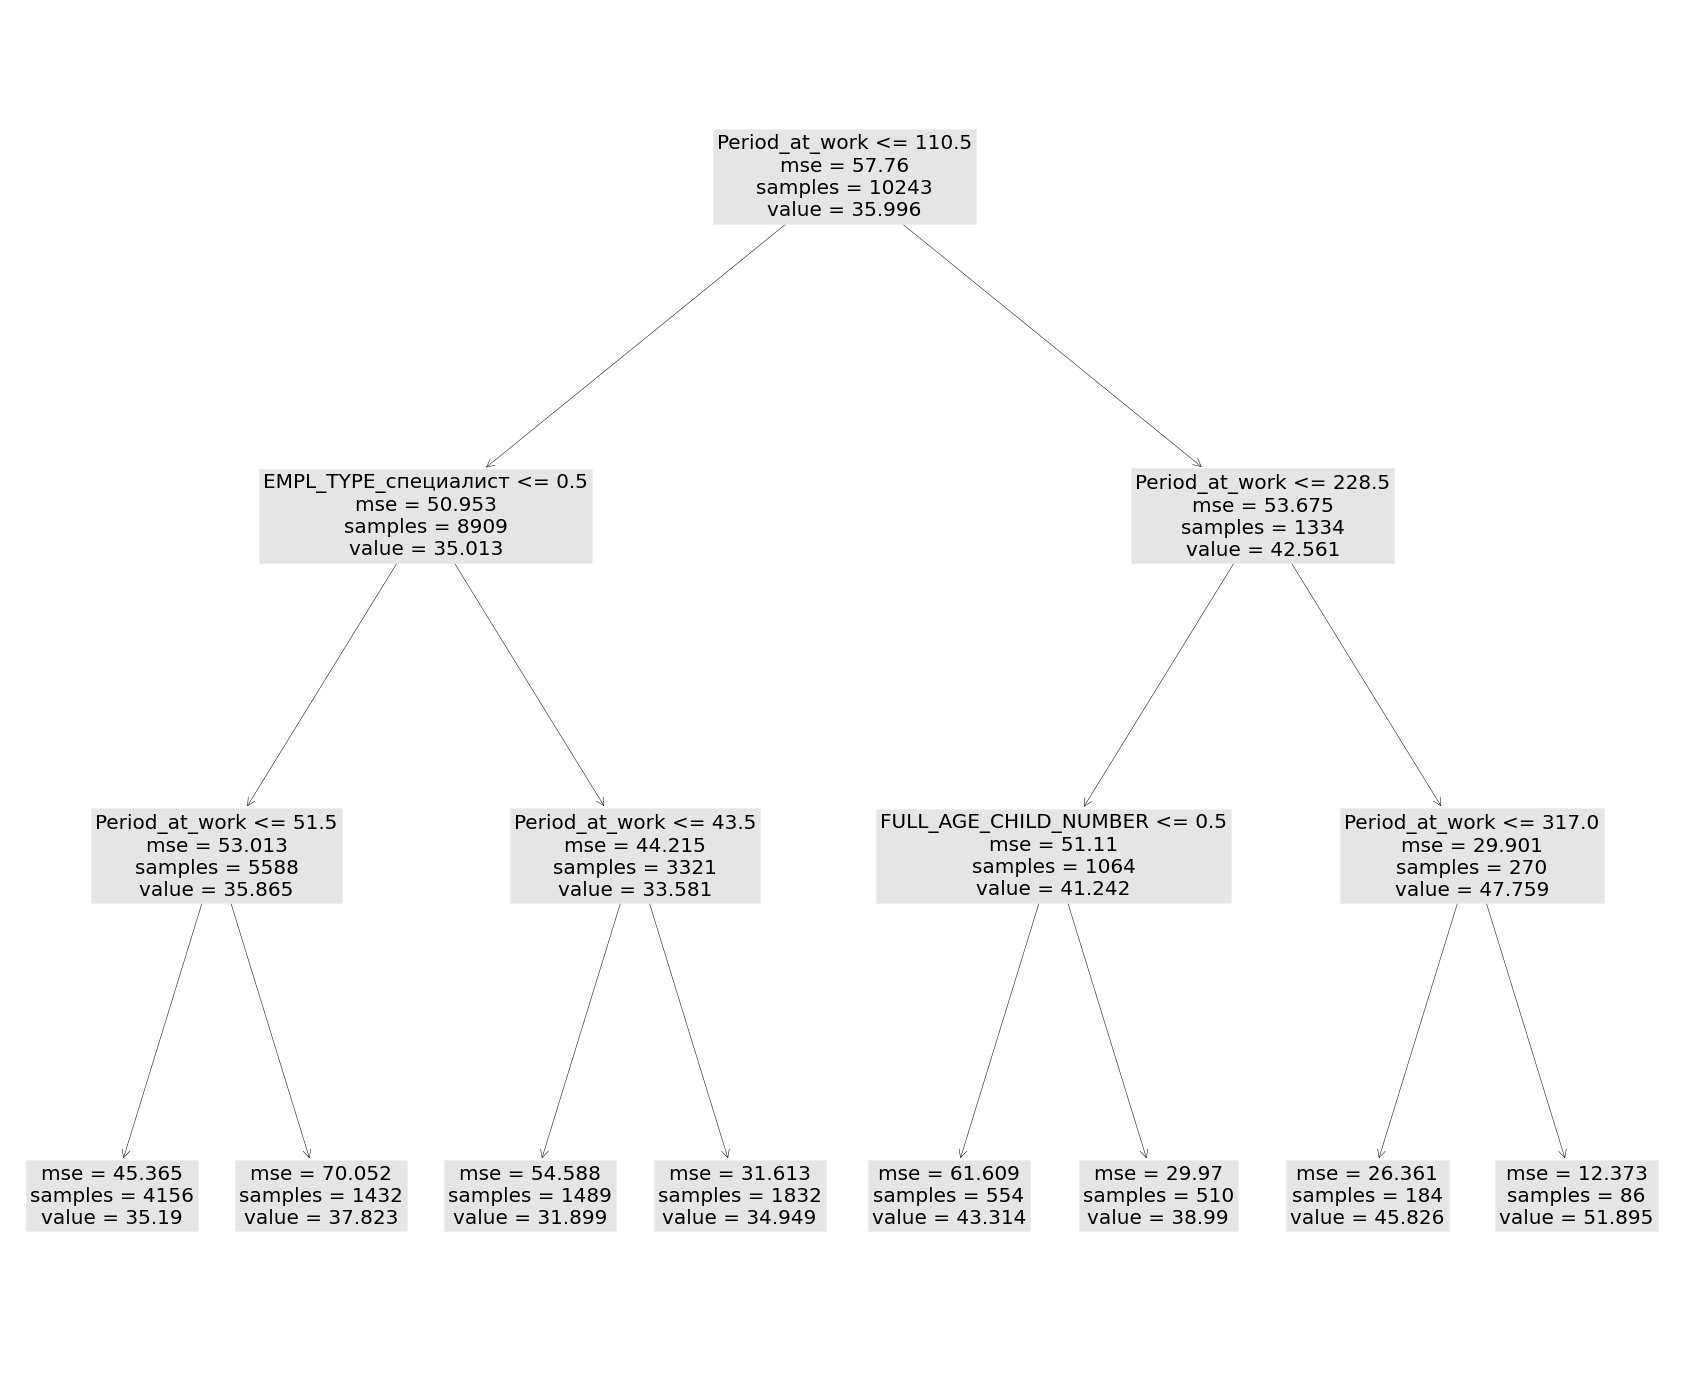

In [ ]:
X = df.drop(columns=['age'])
y = df['age']

d3 = DecisionTreeRegressor(random_state=42, max_depth=3)

d3.fit(X, y)

plt.figure(figsize=(30, 25))

plot_tree(d3, feature_names=X.columns, fontsize=20)
plt.show()



Проведя обучение регрессионной модели - решающего дерева были получены следующие примерные группы заемщиков:

1. 35 летний заемщик - не специалист с опытом работы менее 2ух месяцев
2. 38 летний заемщик - не специалист с опытом работы от 2ух месяцев
до 4 месяцев
3. 32 летний заемщик - специалист с опытом работы менее полутора месяцев
4. 35 летний заемщик - специалист с опытом работы от полутора до 4 месяцев
5. 43 летний заемщик с опытом работы от 4 до 7 месяцев, не имеющий новорожденных детей
6. 39 летний заемщик с опытом работы от 4 до 7 месяцев имеющий новорожденных детей
7. 46 летний заемщик с опытом работы от 7 месяцев до 10 месяцев
8. 52 летний заемщик с опытом работы от 10 месяцев


Заметно, что ключевым показателем, по которому дерево предсказывало возраст заемщика был опыт работы

Посмотрим, какие признаки оказались бы значимыми для дерева, если бы мы не ограничивали его обучение

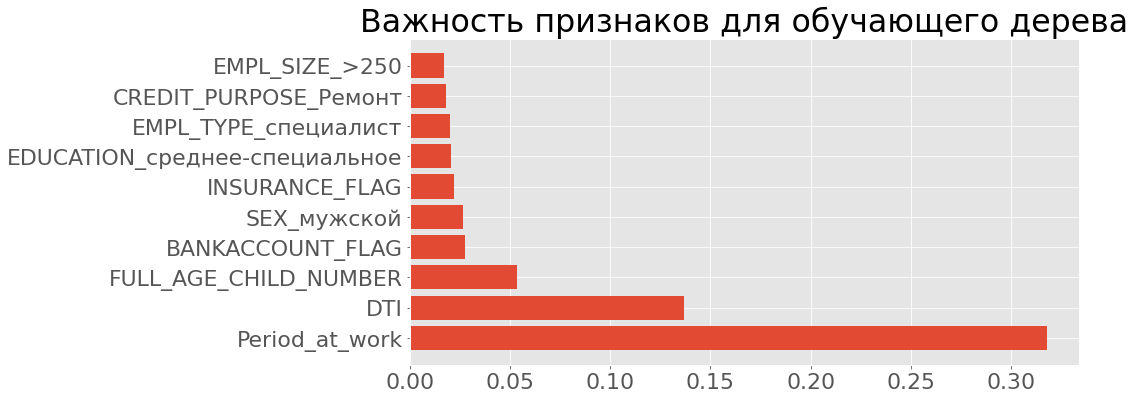

In [ ]:
d3 = DecisionTreeRegressor(random_state=42)
d3.fit(X, y)

features = pd.DataFrame(
    index=X.columns.values,
    data=d3.feature_importances_,
    columns=['importance']
).nlargest(10, 'importance')

plt.figure(figsize=(12, 6))
plt.title('Важность признаков для обучающего дерева')
plt.barh(features['importance'].index, features['importance'].values)

plt.show()


Вновь наиболее важным признаком становится время работы на последнем рабочем месте, кроме того в пятерку важнейших признаков входят:
- возраст ребенка
- количество банковских счетов заемщика
- половая принадлежность
- соотношение долга к доходам


Резюмируя, можно выделить следующие группы заемщиков:

1. Заемщик 40-50 лет с большим опытом работы
2. Заемщик 35-45 лет с меньшим опытом работы не имеющий новорожденных детей (как риск дополнительных непредвиденных расходов)
3. Заемщик - специалист 30-35 лет с небольшим опытом работы
4. Заемщик - неспециалист 30-40 лет с небольшим опытом работы
5. Заемщика с высоким уровнем отношения долгов к доходам
6. Заемщика с низким уровнем отношения долга к доходам

### Кластеризация без учителя (K-means)

Вторым рассмотренным способом кластеризации будет модель ```k-means```

Рассмотрим некоторые ее свойства:

Преимущества:
- Идея работы алгоритма не нагружена сложной математикой
- Тем не менее алгортим точен с математической точки зрения
и позволяет финально определить группы объектов
- Алгоритм не требует значительных ресурсов компьютера

Недостатки:
- Более сложная интерпретация результатов, по сравнению с решающим деревом
- Необходимость зафиксировать изначально некоторые параметры:
    * Количество кластеров
    * Изначальное положение центроидов
- Чувствительность к масштабам признаков, предварительно данные необходимо стандартизировать или отмасштабировать любым скалером
- Зависимость от наличия выбросов в данных

In [ ]:
# стандартизируем данные, для того чтобы кластеризация в зависимости от масштаба данных отработала корректно

sc = StandardScaler()
df_kmeans = df.copy()

for col in df_kmeans.columns:

    if df_kmeans[col].nunique() >= 20:
        df_kmeans[col] = sc.fit_transform(df_kmeans[col].values.reshape(-1, 1))

df_kmeans.head()

,INSURANCE_FLAG,DTI,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,BANKACCOUNT_FLAG,Period_at_work,age,SEX_мужской,EMPL_PROPERTY_Другое,EMPL_PROPERTY_Информационные технологии,...,EDUCATION_ученая степень,CREDIT_PURPOSE_Лечение,CREDIT_PURPOSE_Обучение,CREDIT_PURPOSE_Отпуск,CREDIT_PURPOSE_Покупка автомобиля,CREDIT_PURPOSE_Покупка бытовой техники,CREDIT_PURPOSE_Покупка земли,CREDIT_PURPOSE_Покупка мебели,CREDIT_PURPOSE_Покупка недвижимости/ строительство,CREDIT_PURPOSE_Ремонт
ID,,,,,,,,,,,,,,,,,,,,,
1000004,1.0,-1.007783,0,0,0.0,0.162420,1.842599,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1000024,0.0,-0.126804,0,0,0.0,-0.271184,-0.131091,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1000044,0.0,0.607344,0,0,0.0,-0.878231,-1.446885,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1000064,0.0,0.093440,1,0,1.0,0.179765,-0.657409,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1000084,1.0,-0.787538,2,0,0.0,1.966217,1.842599,1,1,0,...,0,0,0,0,0,0,0,0,0,1


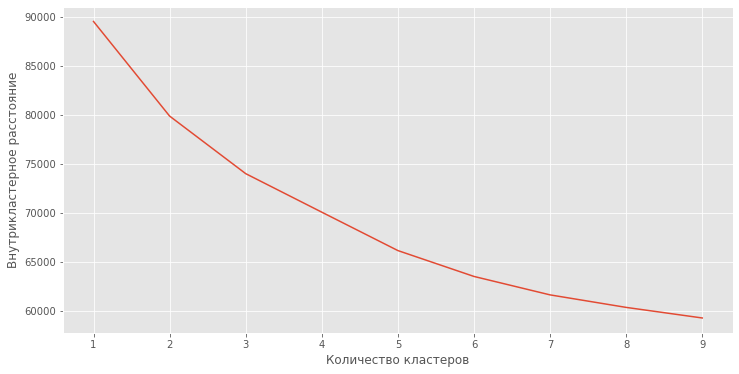

In [ ]:
# определяем оптимальное кол-во кластеров

results = []
for n in range(1, 10):
    km_cluster = KMeans(n_clusters=n, init='k-means++', random_state=41, copy_x=True)
    km_cluster.fit(df_kmeans)
    tmp = {
        'n_clusters': n,
        'inertia': km_cluster.inertia_,
    }

    results.append(tmp)

fig, axes = plt.subplots(figsize=(12, 6))

res = pd.DataFrame(results).set_index('n_clusters')

axes.plot(res['inertia'], label='inertia')

axes.set_xlabel('Количество кластеров')
axes.set_ylabel('Внутрикластерное расстояние')

plt.show()

Значительного и резкого спада в выбранной метрике качества не наблюдается, тем не менее, 4 - 5 кластеров кажутся оптимальной величиной, так как меньшее количество кластеров ведет к увеличению внутрикластерного расстояния, а большее количество - к усложнению интерпретации результатов

Количество объектов в каждом кластере
0    4134
1    3130
2    1649
4     742
3     588
Name: cluster, dtype: int64




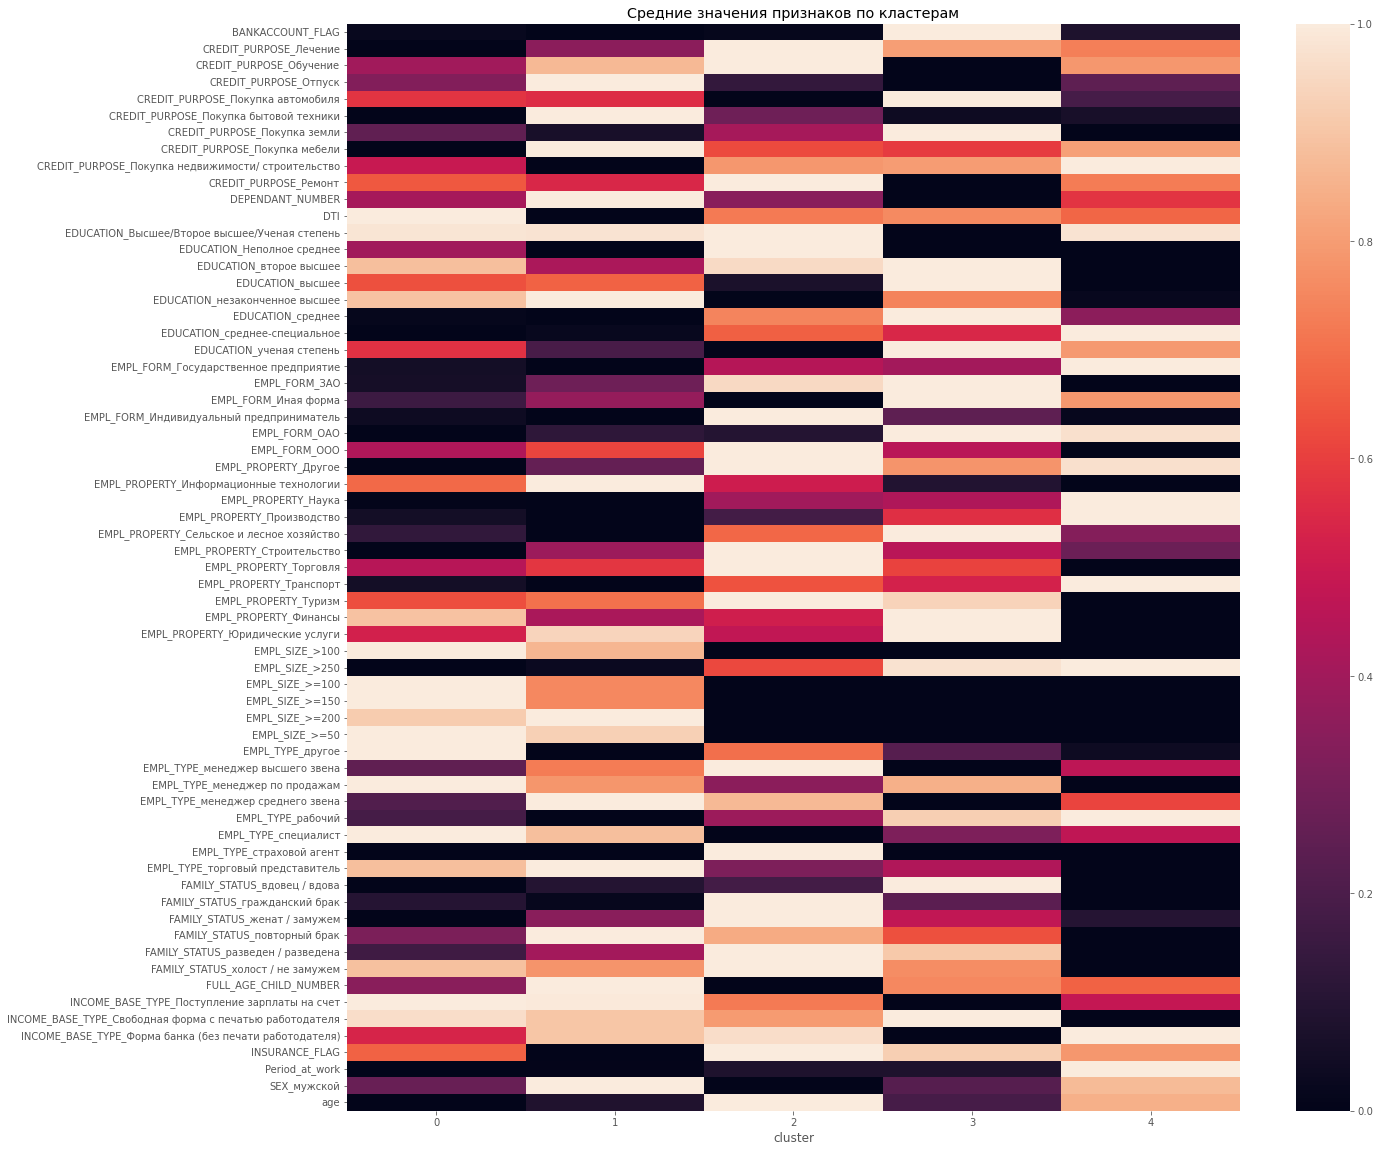

In [ ]:
n_clusters = 5
km_cluster = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, copy_x=True)
km_cluster.fit(df_kmeans)

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
print('Количество объектов в каждом кластере')
df['cluster'] = km_cluster.labels_
print(df['cluster'].value_counts())

df_test = df.groupby('cluster').mean()

for col in df_test.columns:
    df_test[col] = sc.fit_transform(df_test[col].values.reshape(-1, 1))

print()
print()

plt.figure(figsize=(20, 20))
plt.title('Средние значения признаков по кластерам')
sns.heatmap(df_test.T.sort_index())

matplotlib.rcParams.update({'font.size': 22})
plt.show()

### Результаты
Подведем итоги и выделим те кластерные сегменты, которые получилось выявить с помощью модели ```k-means```

Рассмотрим некоторые ее свойства:

0 - кластер :
- наибольшее число наблюдений
- самые молодые заемщики
- наибольший показатель DTI по сравнению с другими кластерами
- преобладают специалисты и менеджеры
- занимаемые должности работников внутри кластера разнообразны, неявно выделяется сектор Финансы
- количество детей - одно из наименьших среди всех кластеров
- самые низкие зарплаты
- самый маленький опыт работы

1 - кластер :
- самый низкий показатель DTI среди всех кластеров
- превалирующее число людей, состоящих в повторном браке
- люди с наибольшим количеством детей
- основные должности: торговые представители и менеджеры среднего звена
- средний уровень заработной платы
- основные цели займа - покупка бытовой техники или мебели

2 - кластер:
- превалирующее число людей с высшим образованием
- основые сферы: торговля и транспорт
- наиболее частые занимаемые должности работников - менеджеры высшего звена и страховые агенты
- самые возрастные заемщики
- превалирующее число людей, состоящих в браке

3 - кластер:
- возраст агентов кластера чуть выше среднего
- люди с высшим образованием
- заработные платы выше среднего
- основные цели займа внутри кластера - покупка автомобиля или недвижимости

4 - кластер:
- возраст группы выше среднего
- превалирующая группа - работники-специалисты
- самый высокий уровень заработной платы
- основные сферы: наука и производство
- люди с высшим образованием
- основная цель займа: покупка недвижимости и строительство

